# Cervical Cancer Detection CNNs (VGG16 module)

Cervical cancer detection using Convolutional Neural Networks (CNNs) involves leveraging deep learning models to identify and classify cervical cancer in medical images, such as Pap smear slides or cervical tissue scans. Among the commonly used architectures, VGG16 is a popular choice due to its simplicity and proven performance in image recognition tasks.

#### Overview of VGG16 for Cervical Cancer Detection 

<p>
    1. <b>VGG16 Architecture:</b>
</p>

<ul>
    <li> VGG16 is a 16-layer deep CNN model pre-trained on the ImageNet dataset, which can extract hierarchical features from images. </li>
    <li> It consists of convolutional layers, max-pooling layers, and fully connected layers. </li>
    <li> The model is known for its ability to capture detailed features and high-level representations, making it effective for medical image analysis. </li>
</ul>

<p>
    2. <b>Preprocessing:</b>
</p>

<ul>
    <li> Input images (e.g., cervical cell images) are preprocessed by resizing them to match the input dimensions required by VGG16 (typically 224x224 pixels). </li>
    <li> Image augmentation techniques, such as rotation, scaling, and flipping, may be applied to improve model generalization. </li>
</ul>

<p>
    3. <b>Transfer Learning:</b>
</p>

<ul>
    <li> Since VGG16 is pre-trained on ImageNet, transfer learning is employed by fine-tuning the model on cervical cancer datasets. </li>
    <li> The final fully connected layers are replaced with custom layers tailored for binary (cancer vs. no cancer) or multi-class classification. </li>
</ul>

<p>
    4. <b>Use in Cervical Cancer Detection:</b>
</p>

<ul>
    <li> The model analyzes cervical cell features to predict the presence or stage of cancer. </li>
    <li> It can be used for tasks such as: </li>
    <ul>
        <li> Classifying normal vs. abnormal cells. </li>
        <li> Grading cervical lesions. </li>
        <li> Detecting early signs of malignancy. </li>
    </ul>
</ul>

<p>
    5. <b>Advantages:</b>
</p>

<ul>
    <li> High accuracy and robustness in image recognition tasks. </li>
    <li> Ability to handle complex patterns in medical imaging data. </li>
    <li> Pre-trained weights speed up training and reduce the need for large datasets. </li>
</ul>

<p>
    6. <b>Challenges:</b>
</p>

<ul>
    <li> Requires a significant amount of labeled data for fine-tuning to achieve optimal performance in a medical context. </li>
    <li> Needs explainability tools to interpret decisions for clinical applications. </li>
</ul>

By integrating the VGG16 module into cervical cancer detection pipelines, can build reliable, automated systems to assist in early diagnosis and improve patient outcomes.

## Importing Required Libraries to Install

In [2]:
!pip3 install -U scipy matplotlib
!pip install scikit-learn==0.24.2
!pip install prettytable

    opencv-python (>=3.) ; extra == 'all'
                  ~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [951 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_system != "AIX" and platform_python_implementation == "CPython"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_system != "AIX" and platform_python_implementation != "CPython"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: marke

    opencv-python (>=3.) ; extra == 'all'
                  ~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Importing Required Packages

In [3]:
import numpy as np 
import pandas as pd 
import os
import glob
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
#from sklearn.utils import copy_if_needed
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
from concurrent import futures
import threading
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import datetime
from prettytable import PrettyTable

## Reading Datasets

In [4]:
print(os.listdir("/Users/ankurkohli007/Documents/cervial_cnn/kaggle"))



base_dir = os.path.join('/Users/ankurkohli007/Documents/cervial_cnn/kaggle/train/train')
type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

len(type1_files),len(type2_files),len(type3_files)

['test_stg2', '.DS_Store', 'test', 'additional_Type_3_v2', 'additional_Type_2_v2', 'additional_Type_1_v2', 'train']


(250, 781, 450)

## Creating a DataFrame for Mapping Images to Cancer Types

In [5]:
#Building a dataframe mapping images and Cancer type
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/Users/ankurkohli007/Documents/cervial_cnn/kag...,Type_1
1,/Users/ankurkohli007/Documents/cervial_cnn/kag...,Type_2
2,/Users/ankurkohli007/Documents/cervial_cnn/kag...,Type_2
3,/Users/ankurkohli007/Documents/cervial_cnn/kag...,Type_2
4,/Users/ankurkohli007/Documents/cervial_cnn/kag...,Type_3


## Split Dataset

<p>
    The dataset in the code is split into training, validation (dev), and test sets in the ratio of 60:10:30 to ensure effective training, validation, and evaluation of the machine learning model. Here’s why this splitting is necessary:
</p>

#### Purpose of Splitting the Dataset

<p>
    1. Training Set (60% of Data):
</p>

<ul>
    <li> The training set is used to train the model. </li>
    <li> During training, the model learns patterns and relationships in the data to minimize the loss function (e.g., classification error). </li>
    <li> The training set provides the primary data for adjusting model weights. </li>
</ul>

<p>
    2. Validation (Dev) Set (10% of Data):
</p>

<ul>
    <li> The validation set is used to fine-tune the model and hyperparameters, such as learning rate, number of layers, or regularization strength. </li>
    <li> It acts as unseen data during training to evaluate how well the model generalizes. </li>
    <li> The validation set helps prevent overfitting by ensuring the model is not memorizing the training data. </li>
</ul>

<p>
    3. Test Set (30% of Data):
</p>

<ul>
    <li> The test set is used to evaluate the final model performance after training is complete. </li>
    <li> This dataset is not involved in the training or validation process. </li>
    <li> It provides an unbiased estimate of how the model will perform on new, unseen data in real-world scenarios. </li>
</ul>

#### Why Splitting Is Essential?

<ul>
    <li> <b>Avoid Overfitting:</b> By separating data, the model's ability to generalize is assessed, preventing overfitting to the training data. </li>
    <li> <b>Hyperparameter Tuning:</b> Validation data is critical for choosing the best model configuration without compromising the integrity of the test set. </li>
    <li> <b>Performance Metrics:</b> Test data is necessary to measure final accuracy, precision, recall, F1 score, or other metrics.</li>
    <li> <b>Replicability:</b> The split ensures consistent evaluation and comparison of model performance across different datasets. </li>
</ul>

#### The Chosen Ratios (60:10:30)

<ul>
    <li> <b>60% Training:</b> Sufficient data for the model to learn robust patterns. </li>
    <li> <b>10% Validation:</b> Small but representative subset to tune the model effectively. </li>
    <li> <b>30% Test:</b> Large enough to provide reliable and unbiased evaluation metrics.
</ul>

By splitting the data, the code ensures that the model is trained and evaluated in a way that closely mimics real-world conditions.

In [6]:
#split training,dev and test set : 60:10:30

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))


(932,) (104,) (445,)
Train: Counter({'Type_2': 494, 'Type_3': 285, 'Type_1': 153}) 
Val: Counter({'Type_2': 61, 'Type_3': 27, 'Type_1': 16}) 
Test: Counter({'Type_2': 226, 'Type_3': 138, 'Type_1': 81})


## Dataset Dimensions Summary

In [7]:
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_6: working on img num: 931
Min Dimensions: [224 224   3]
Avg Dimensions: [224. 224.   3.]
Median Dimensions: [224. 224.   3.]
Max Dimensions: [224 224   3]


## Loading and Preprocessing Images in Parallel for Train, Validation, and Test Sets

In [8]:
IMG_DIMS = (224, 224)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape 

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_7: working on img num: 931

Loading Validation Images:
ThreadPoolExecutor-1_5: working on img num: 0
ThreadPoolExecutor-1_0: working on img num: 103

Loading Test Images:
ThreadPoolExecutor-1_7: working on img num: 0
ThreadPoolExecutor-1_5: working on img num: 444


((932, 224, 224, 3), (104, 224, 224, 3), (445, 224, 224, 3))

## Viewing some sample images

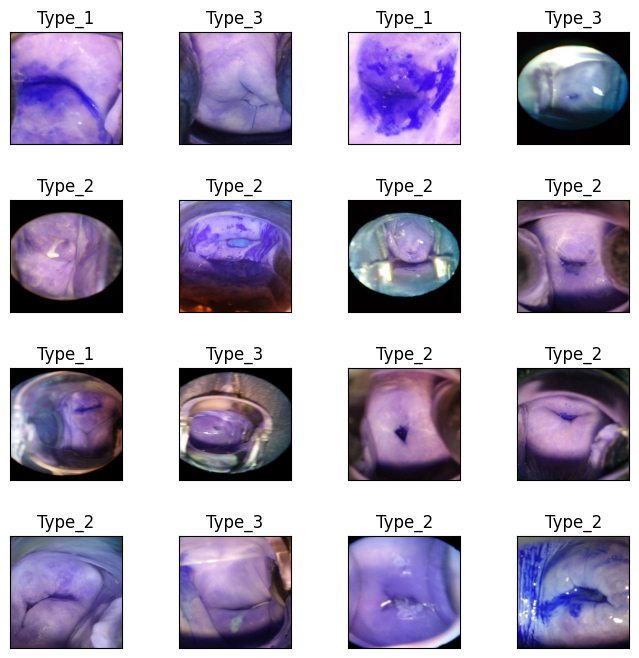

In [9]:
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

## Encoding Text Categories into Labels and Preparing Data for Model Training

In [10]:
#encode text categories with labels
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 2
INPUT_SHAPE = (224, 224, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = to_categorical(train_labels_enc, num_classes=3)
val_labels_1hotenc = to_categorical(val_labels_enc, num_classes=3)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_2' 'Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1'] [1 2 0 0 1 0]
['Type_2' 'Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1'] [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


## Scaling the Test Set and One-Hot Encoding the Test Labels

In [11]:
#scaling the test set and one-hot encoding the test labels
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

le = LabelEncoder()
le.fit(test_labels)
test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = to_categorical(test_labels_enc, num_classes=3)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_2' 'Type_1' 'Type_2' 'Type_3' 'Type_1' 'Type_3'] [1 0 1 2 0 2]
['Type_2' 'Type_1' 'Type_2' 'Type_3' 'Type_1' 'Type_3'] [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


## VGG16 Model

In [12]:
vgg16Net = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg16Net.trainable = False
# Freeze the layers
for layer in vgg16Net.layers:
    layer.trainable = False
    
base_vgg16 = vgg16Net
base_out_vgg16 = base_vgg16.output
pool_out_vgg16 = tf.keras.layers.Flatten()(base_out_vgg16)
hidden1_vgg16 = tf.keras.layers.Dense(512, activation='relu')(pool_out_vgg16)
drop1_vgg16 = tf.keras.layers.Dropout(rate=0.3)(hidden1_vgg16)
hidden2_vgg16 = tf.keras.layers.Dense(512, activation='relu')(drop1_vgg16)
drop2_vgg16 = tf.keras.layers.Dropout(rate=0.3)(hidden2_vgg16)
out_vgg16 = tf.keras.layers.Dense(3, activation='softmax')(drop2_vgg16)

vgg16_model = tf.keras.Model(inputs=base_vgg16.input, outputs=out_vgg16)
vgg16_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Training the VGG16 Model and Tracking Training Time

In [13]:
vgg16_start = time.time()
vgg16_history = vgg16_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
vgg16_stop = time.time()

Epoch 1/2


2025-02-23 00:36:24.970461: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 104s 7s/step - loss: 1.2393 - accuracy: 0.4785 - val_loss: 0.9040 - val_accuracy: 0.5865
Epoch 2/2
15/15 [==============================] - 104s 7s/step - loss: 1.0271 - accuracy: 0.5064 - val_loss: 0.9630 - val_accuracy: 0.5192


## Summary of VGG16 

14/14 [==============================] - 39s 3s/step - loss: 1.0226 - accuracy: 0.4921
+--------------------------------+--------+
|             VGG16              |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 50.64  |
|       Test Accuracy in %       | 49.21  |
|         Test Loss in %         | 102.26 |
| Time Taken To Train in Seconds | 207.19 |
+--------------------------------+--------+


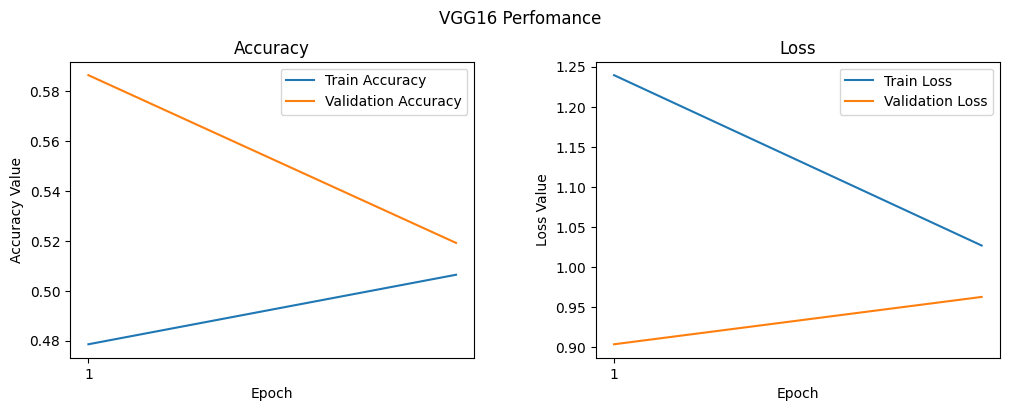

In [14]:
vgg16_trainTime=vgg16_stop-vgg16_start
vgg16_model_accuracy = vgg16_history.history['accuracy'][np.argmin(vgg16_history.history['loss'])]
vgg16_model_score=vgg16_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
vgg16_Summary = PrettyTable(["VGG16"," "])
vgg16_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(vgg16_model_accuracy*100)])
vgg16_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(vgg16_model_score[1]*100)])
vgg16_Summary.add_row(["Test Loss in %", "{:.2f}".format(vgg16_model_score[0]*100)])
vgg16_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(vgg16_trainTime)])
print(vgg16_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(vgg16_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, vgg16_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, vgg16_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, vgg16_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, vgg16_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## VGG19

In [19]:
#using VGG19 pre-trained model
vgg19Net = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg19Net.trainable = False
# Freeze the layers
for layer in vgg16Net.layers:
    layer.trainable = False
    
base_vgg19 = vgg16Net
base_out_vgg19= base_vgg19.output
pool_out_vgg19 = tf.keras.layers.Flatten()(base_out_vgg19)
hidden1_vgg19 = tf.keras.layers.Dense(512, activation='relu')(pool_out_vgg19)
drop1_vgg19 = tf.keras.layers.Dropout(rate=0.3)(hidden1_vgg19)
hidden2_vgg19 = tf.keras.layers.Dense(512, activation='relu')(drop1_vgg19)
drop2_vgg19 = tf.keras.layers.Dropout(rate=0.3)(hidden2_vgg19)
out_vgg19 = tf.keras.layers.Dense(3, activation='softmax')(drop2_vgg19)

vgg19_model = tf.keras.Model(inputs=base_vgg19.input, outputs=out_vgg19)
vgg19_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
vgg19_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:
vgg19_start = time.time()
vgg19_history = vgg19_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
vgg19_stop = time.time()

Epoch 1/2
15/15 [==============================] - 99s 7s/step - loss: 1.3469 - accuracy: 0.4517 - val_loss: 0.9411 - val_accuracy: 0.5865
Epoch 2/2
15/15 [==============================] - 95s 6s/step - loss: 1.0165 - accuracy: 0.4882 - val_loss: 0.9361 - val_accuracy: 0.5865


## VGG19 Summary

14/14 [==============================] - 42s 3s/step - loss: 1.0272 - accuracy: 0.5079
+--------------------------------+--------+
|             Vgg19              |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 48.82  |
|       Test Accuracy in %       | 50.79  |
|         Test Loss in %         | 102.72 |
| Time Taken To Train in Seconds | 194.39 |
+--------------------------------+--------+


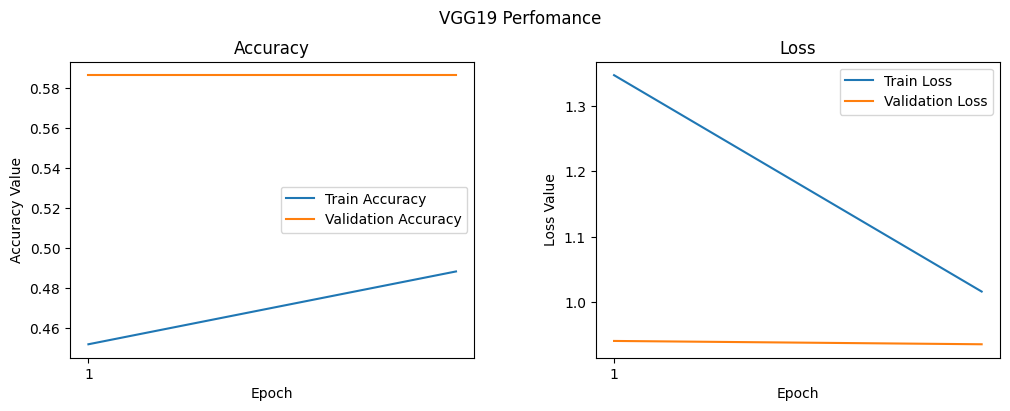

In [21]:
vgg19_trainTime=vgg19_stop-vgg19_start
vgg19_model_accuracy = vgg19_history.history['accuracy'][np.argmin(vgg19_history.history['loss'])]
vgg19_model_score=vgg19_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
vgg19_Summary = PrettyTable(["Vgg19"," "])
vgg19_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(vgg19_model_accuracy*100)])
vgg19_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(vgg19_model_score[1]*100)])
vgg19_Summary.add_row(["Test Loss in %", "{:.2f}".format(vgg19_model_score[0]*100)])
vgg19_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(vgg19_trainTime)])
print(vgg19_Summary)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG19 Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(vgg19_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, vgg19_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, vgg19_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, vgg19_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, vgg19_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Xception

In [23]:
#using Xception trained model
Xception = tf.keras.applications.Xception(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
Xception.trainable = False
# Freeze the layers
for layer in Xception.layers:
    layer.trainable = False
    
base_Xception = Xception
base_out_Xception = base_Xception.output
pool_out_Xception = tf.keras.layers.Flatten()(base_out_Xception)
hidden1_Xception = tf.keras.layers.Dense(512, activation='relu')(pool_out_Xception)
drop1_Xception = tf.keras.layers.Dropout(rate=0.3)(hidden1_Xception)
hidden2_Xception = tf.keras.layers.Dense(512, activation='relu')(drop1_Xception)
drop2_Xception = tf.keras.layers.Dropout(rate=0.3)(hidden2_Xception)
out_Xception = tf.keras.layers.Dense(3, activation='softmax')(drop2_Xception)

Xception_model = tf.keras.Model(inputs=base_Xception.input, outputs=out_Xception)
Xception_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 28, 28, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 28, 28, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 28, 28, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 14, 14, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 14, 14, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 14, 14, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 14, 14, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 14, 14, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 14, 14, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 14, 14, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 14, 14, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 14, 14, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [25]:
Xception_start = time.time()
Xception_history = Xception_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
Xception_stop = time.time()

Epoch 1/2
15/15 [==============================] - 34s 2s/step - loss: 2.5533 - accuracy: 0.4195 - val_loss: 1.0715 - val_accuracy: 0.5096
Epoch 2/2
15/15 [==============================] - 33s 2s/step - loss: 1.1268 - accuracy: 0.4764 - val_loss: 1.0197 - val_accuracy: 0.5192


## Xception Summary

14/14 [==============================] - 14s 972ms/step - loss: 1.0669 - accuracy: 0.4067
+--------------------------------+--------+
|            Xception            |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 47.64  |
|       Test Accuracy in %       | 40.67  |
|         Test Loss in %         | 106.69 |
| Time Taken To Train in Seconds | 67.31  |
+--------------------------------+--------+


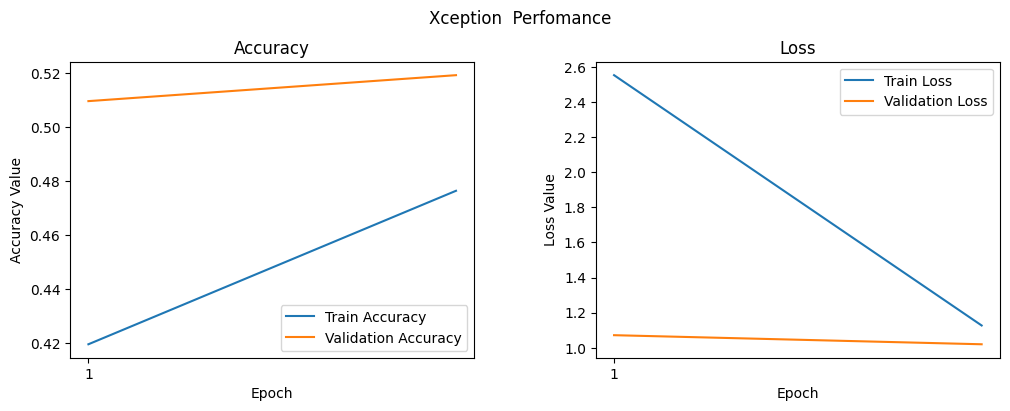

In [26]:
Xception_trainTime=Xception_stop-Xception_start
Xception_model_accuracy = Xception_history.history['accuracy'][np.argmin(Xception_history.history['loss'])]
Xception_model_score=Xception_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
Xception_Summary = PrettyTable(["Xception"," "])
Xception_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(Xception_model_accuracy*100)])
Xception_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(Xception_model_score[1]*100)])
Xception_Summary.add_row(["Test Loss in %", "{:.2f}".format(Xception_model_score[0]*100)])
Xception_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(Xception_trainTime)])
print(Xception_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception  Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(Xception_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, Xception_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, Xception_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, Xception_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, Xception_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Summary

+------------+---------------------------+--------------------------+--------------------------------+
| Model Name | Model Train Accuracy in % | Model Test Accuracy in % | Time Taken To Train in Seconds |
+------------+---------------------------+--------------------------+--------------------------------+
|   Vgg16    |           50.64           |          49.21           |             207.19             |
|   Vgg19    |           48.82           |          50.79           |             194.39             |
|  Xception  |           47.64           |          40.67           |             67.31              |
+------------+---------------------------+--------------------------+--------------------------------+


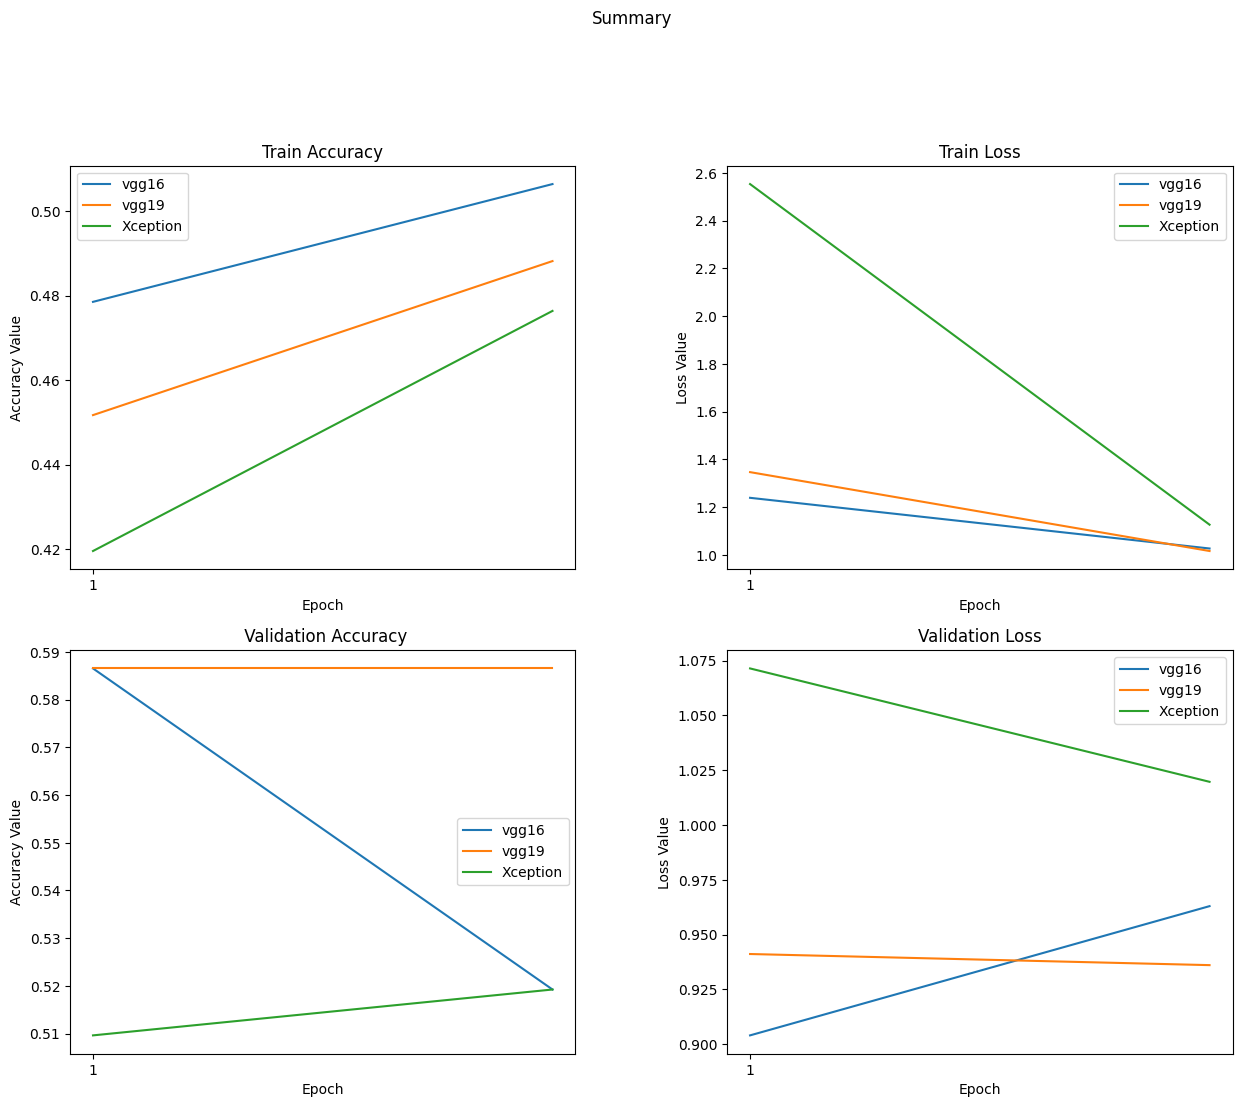

In [31]:
Summary = PrettyTable(["Model Name", "Model Train Accuracy in %", "Model Test Accuracy in %","Time Taken To Train in Seconds"])
Summary.add_row(["Vgg16", "{:.2f}".format(vgg16_model_accuracy*100),"{:.2f}".format(vgg16_model_score[1]*100),"{:.2f}".format(vgg16_trainTime)])
Summary.add_row(["Vgg19", "{:.2f}".format(vgg19_model_accuracy*100),"{:.2f}".format(vgg19_model_score[1]*100),"{:.2f}".format(vgg19_trainTime)])
Summary.add_row(["Xception", "{:.2f}".format(Xception_model_accuracy*100),"{:.2f}".format(Xception_model_score[1]*100),"{:.2f}".format(Xception_trainTime)])


print(Summary)
f, ax = plt.subplots(2, 2, figsize=(15, 12))
t = f.suptitle('Summary', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = list(range(1,3))


ax[0,0].plot(epoch_list, vgg16_history.history['accuracy'], label='vgg16')
ax[0,0].plot(epoch_list, vgg19_history.history['accuracy'], label='vgg19')
ax[0,0].plot(epoch_list, Xception_history.history['accuracy'], label='Xception')
ax[0,0].set_xticks(np.arange(1, max_epoch, 5))
ax[0,0].set_ylabel('Accuracy Value')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_title('Train Accuracy')
l1 = ax[0,0].legend(loc="best")



ax[0,1].plot(epoch_list, vgg16_history.history['loss'], label='vgg16')
ax[0,1].plot(epoch_list, vgg19_history.history['loss'], label='vgg19')
ax[0,1].plot(epoch_list, Xception_history.history['loss'], label='Xception')
ax[0,1].set_xticks(np.arange(1, max_epoch, 5))
ax[0,1].set_ylabel('Loss Value')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_title('Train Loss')
l2 = ax[0,1].legend(loc="best")



ax[1,0].plot(epoch_list, vgg16_history.history['val_accuracy'], label='vgg16')
ax[1,0].plot(epoch_list, vgg19_history.history['val_accuracy'], label='vgg19')
ax[1,0].plot(epoch_list, Xception_history.history['val_accuracy'], label='Xception')
ax[1,0].set_xticks(np.arange(1, max_epoch, 5))
ax[1,0].set_ylabel('Accuracy Value')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_title(' Validation Accuracy')
l3 = ax[1,0].legend(loc="best")


ax[1,1].plot(epoch_list, vgg16_history.history['val_loss'], label='vgg16')
ax[1,1].plot(epoch_list, vgg19_history.history['val_loss'], label='vgg19')
ax[1,1].plot(epoch_list, Xception_history.history['val_loss'], label='Xception')
ax[1,1].set_xticks(np.arange(1, max_epoch, 5))
ax[1,1].set_ylabel('Loss Value')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_title('Validation Loss')
l4 = ax[1,1].legend(loc="best")

## Predicition 

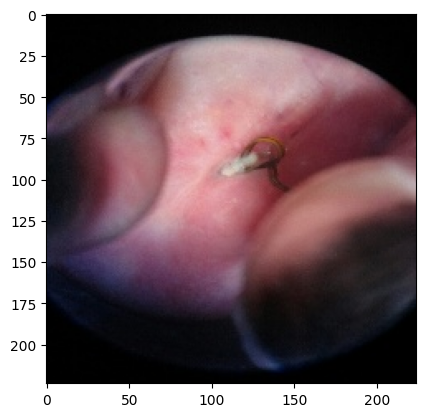

ThreadPoolExecutor-1_3: working on img num: 0
######Generate a vgg16 prediction########
1/1 [==============================] - 0s 152ms/step
Test image is Classified as Type 2 with 43.36% in vgg16
                                                                 
######Generate a vgg19 prediction########
1/1 [==============================] - 0s 110ms/step
Test image is Classified as Type 2 with 64.05% in vgg19
                                                                 
######Generate a Xception  prediction########
1/1 [==============================] - 0s 66ms/step
Test image is Classified as Type 2 with 36.54% in Xception


In [35]:
from matplotlib import pyplot
img='/Users/ankurkohli007/Documents/cervial_cnn/kaggle/test/test/3.jpg'
data = pyplot.imread(img)
pyplot.imshow(data)
ax = pyplot.gca()
pyplot.show()


test1_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate([img])]
test1_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test1_data_inp],
                        [record[1] for record in test1_data_inp],
                        [record[2] for record in test1_data_inp])
test1_data = np.array(list(test1_data_map))
test1_imgs_scaled = test1_data / 255.

print("######Generate a vgg16 prediction########")
vgg16_prediction = vgg16_model.predict(test1_imgs_scaled)

if (vgg16_prediction[0][0] >= vgg16_prediction[0][1]) and (vgg16_prediction[0][0] >= vgg16_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in vgg16".format(vgg16_prediction[0][0]*100))
elif (vgg16_prediction[0][1] >= vgg16_prediction[0][0]) and (vgg16_prediction[0][1] >= vgg16_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in vgg16".format(vgg16_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in vgg16".format(vgg16_prediction[0][2]*100))
    
print("                                                                 ")    
print("######Generate a vgg19 prediction########")
vgg19_prediction = vgg19_model.predict(test1_imgs_scaled)

if (vgg19_prediction[0][0] >= vgg19_prediction[0][1]) and (vgg19_prediction[0][0] >= vgg19_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in vgg19".format(vgg19_prediction[0][0]*100))
elif (vgg19_prediction[0][1] >= vgg19_prediction[0][0]) and (vgg19_prediction[0][1] >= vgg19_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in vgg19".format(vgg19_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in vgg19".format(vgg19_prediction[0][2]*100))
    
    
print("                                                                 ")    
print("######Generate a Xception  prediction########")
Xception_prediction = Xception_model.predict(test1_imgs_scaled)

if (Xception_prediction[0][0] >= Xception_prediction[0][1]) and (Xception_prediction[0][0] >= Xception_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in Xception".format(Xception_prediction[0][0]*100))
elif (Xception_prediction[0][1] >= Xception_prediction[0][0]) and (Xception_prediction[0][1] >= Xception_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in Xception".format(Xception_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in Xception".format(Xception_prediction[0][2]*100))